In [1]:
# --- KNN --- #

This code imports a mix of libraries needed for handling files, processing audio, and building machine learning models. It uses `librosa` for audio feature extraction, `sklearn` for training and evaluating models, and `matplotlib`/`seaborn` for creating visualizations. It also suppresses warnings related to audio signal processing to keep the output clean while running the code.

In [2]:
import os
import warnings
import glob
import librosa
import librosa.display
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset

from sklearn import svm, model_selection
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import learning_curve

# Suppress specific warning about n_fft size from librosa
warnings.filterwarnings("ignore", message="n_fft=1024 is too large for input signal")
warnings.filterwarnings("ignore", message="n_fft=2048 is too large for input signal")

# Libraries like os, glob, and librosa are imported for file handling, audio processing, 
# and visualization. sklearn and pickle are used for model training, evaluation, and saving.

This code sets up the directories for loading and saving data, specifically targeting the `normalized` folder for input and the `working` directory for output. It then counts and sums the number of `.wav` files in each emotion category (Anger, Happiness, Sadness, Neutral) within the training data, and prints the total number of audio files across all categories.

In [3]:
# Loading audio files

# input_dir = '/kaggle/input'
# for root, dirs, files in os.walk(input_dir):
#     for dir_name in dirs:
#         print(os.path.join(root, dir_name))

input_dir = '/kaggle/input/normalized'
output_dir = "/kaggle/working"

# Emotions
categories = ["Anger", "Happiness", "Sadness", "Neutral"]

# Count files in each category folder and get the combined total
train_total = 0
for category in categories:
    category_path = os.path.join(input_dir, category)
    audio_files = [f for f in os.listdir(category_path) if f.endswith('.wav')]
    train_total += len(audio_files)

print(f"Total number of files in training data (combined across '{', '.join(categories)}' folders): {train_total}")

Total number of files in training data (combined across 'Anger, Happiness, Sadness, Neutral' folders): 13918


This code defines a function to extract audio features from `.wav` files using `librosa`, including MFCCs, chroma, mel spectrogram, spectral contrast, and tonnetz. It processes audio files from different emotion categories, extracts the features, and splits the dataset into training, validation, and test sets using Hugging Face's `Dataset` format. Finally, it prints the sizes of each dataset split.

In [4]:
# Function to extract features from an audio file
def extract_feature(file_name):
    try:
        # Load the audio file using librosa
        X, sample_rate = librosa.load(file_name)
        
        # Set a consistent, smaller n_fft value for short signals
        n_fft = 512

        # Pad the audio file to at least n_fft length if shorter
        if len(X) < n_fft:
            X = np.pad(X, (0, n_fft - len(X)))

        # Calculate the Short-Time Fourier Transform (STFT)
        stft = np.abs(librosa.stft(X, n_fft=n_fft))

        # Extract Mel-frequency cepstral coefficients (MFCCs)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)

        # Extract chroma feature (pitch class)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)

        # Extract Mel spectrogram
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)

        # Extract spectral contrast
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)

        # Extract tonnetz (harmonic features)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
        
        # Return all features concatenated into a single vector
        return np.hstack([mfccs, chroma, mel, contrast, tonnetz])

    except Exception as e:
        # Handle errors in feature extraction
        print(f"Error extracting features from {file_name}: {e}")
        return None

# Function to parse all audio files from each category and extract features
def parse_audio_files(base_dir, categories):
    features, labels = [], []
    
    # Loop through each category folder
    for category in categories:
        category_path = os.path.join(base_dir, category)
        
        # Get all .wav files in the current category
        audio_files = glob.glob(os.path.join(category_path, '*.wav'))
        
        # Process each audio file
        for fn in audio_files:
            ext_features = extract_feature(fn)
            
            # If feature extraction is successful, append features and label
            if ext_features is not None:
                features.append(ext_features)
                labels.append(category)
    
    # Convert features and labels to numpy arrays
    return np.array(features), np.array(labels)

# Parse the training data with all files per category
tr_features, tr_labels = parse_audio_files(input_dir, categories)

# Convert dataset to Hugging Face format
dataset = Dataset.from_dict({
    "audio": tr_features.tolist(),
    "label": tr_labels.tolist()
})

# Split dataset into training, validation, and test sets
train_val_dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset, val_dataset = train_val_dataset['train'].train_test_split(test_size=0.1, seed=42).values()
test_dataset = train_val_dataset['test']

# Output dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 10020
Validation dataset size: 1114
Test dataset size: 2784


This code converts the audio features and labels from the training, validation, and test datasets into numpy arrays. It then trains a K-Nearest Neighbors (KNN) classifier using the training data, prints a success message, and saves the trained model to a file using `pickle` for later use.

In [5]:
# Convert Dataset objects to numpy arrays
X_train = np.array(train_dataset['audio'], dtype=np.float32)
y_train = np.array(train_dataset['label'], dtype=str)
X_val = np.array(val_dataset['audio'], dtype=np.float32)
y_val = np.array(val_dataset['label'], dtype=str)
X_test = np.array(test_dataset['audio'], dtype=np.float32)
y_test = np.array(test_dataset['label'], dtype=str)

# Train the KNN model
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(X_train, y_train)
print("Model trained successfully on the training dataset.")

# Save the model
filename = 'Ensemble_Model_protocol_knn.sav'
pickle.dump(neigh, open(filename, 'wb'))
print('Model Saved.')

Model trained successfully on the training dataset.
Model Saved.


This code extracts features from `.wav` audio files using `librosa`, including MFCCs, chroma, mel spectrogram, spectral contrast, and tonnetz. It processes all audio files in given categories, combines the features into a single vector for each file, and stores the features along with their respective labels. Afterward, it checks if the test dataset is properly formatted, uses the trained model to make predictions on the test data, and then evaluates the model’s performance by displaying the accuracy score and confusion matrix.

In [6]:
# List to store file names
target_files = []

# Method to extract features from speech using librosa
def extract_feature(file_name):
    try:
        # Load the audio file using librosa
        X, sample_rate = librosa.load(file_name)
        
        # Pad short audio files to ensure they have a minimum length of 512
        if len(X) < 512:
            X = np.pad(X, (0, 512 - len(X)))
        
        # Compute the Short-Time Fourier Transform (STFT)
        stft = np.abs(librosa.stft(X, n_fft=512))
        
        # Extract Mel-frequency cepstral coefficients (MFCCs)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        
        # Extract chroma feature (pitch class)
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
        
        # Extract Mel spectrogram
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        
        # Extract spectral contrast
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T, axis=0)
        
        # Extract tonnetz (harmonic features)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T, axis=0)
        
        # Return all extracted features
        return mfccs, chroma, mel, contrast, tonnetz

    except Exception as e:
        # Handle errors during feature extraction
        print(f"Error extracting features from {file_name}: {e}")
        return None  # Return None if extraction fails

# Updated method to parse all audio files from each category folder
def parse_audio_files(base_dir, categories):
    features, labels = [], []
    
    # Loop through each category folder
    for category in categories:
        category_path = os.path.join(base_dir, category)
        
        # Load all .wav files in the current category folder
        audio_files = glob.glob(os.path.join(category_path, '*.wav'))
        
        # Process each audio file
        for fn in audio_files:
            ext_features = extract_feature(fn)
            
            # If feature extraction is successful, append the features and label
            if ext_features is not None:
                mfccs, chroma, mel, contrast, tonnetz = ext_features
                
                # Combine all features into a single vector
                combined_features = np.hstack([mfccs, chroma, mel, contrast, tonnetz])
                
                # Append the feature and its corresponding label
                features.append(combined_features)
                labels.append(category)  # Use the folder name as the label
                
                # Store the file name for later use
                target_files.append(fn)
                
    # Convert features and labels to numpy arrays
    return np.array(features), np.array(labels)

# Ensure test_dataset is in the proper format
if "audio" in test_dataset.column_names and "label" in test_dataset.column_names:
    # Convert test dataset's "audio" and "label" columns to numpy arrays
    ts_features = np.array(test_dataset["audio"], dtype=np.float32)
    ts_labels = np.array(test_dataset["label"], dtype=str)

    # Predict using the trained model
    prediction = neigh.predict(ts_features)

    # Create and plot confusion matrix
    matrix = confusion_matrix(ts_labels, prediction)
    
    # Get unique classes from the test labels and predictions
    unique_classes = sorted(list(set(ts_labels).union(set(prediction))))

    # Create a DataFrame for the confusion matrix
    df = pd.DataFrame(matrix, columns=unique_classes, index=unique_classes)

    # Display evaluation metrics
    accuracy = accuracy_score(ts_labels, prediction)
    correct_predictions = accuracy_score(ts_labels, prediction, normalize=False)
    print(f'Accuracy Score: {accuracy}')
    print(f'Number of Correct Predictions: {correct_predictions} out of {len(ts_labels)}')
else:
    print("test_dataset must contain 'audio' and 'label' fields. Please verify the dataset format.")


Accuracy Score: 0.9116379310344828
Number of Correct Predictions: 2538 out of 2784


This code evaluates the trained KNN model's performance on the training, validation, and test datasets. It computes accuracy scores for each dataset and generates a confusion matrix heatmap for the test set to visualize classification performance. Additionally, the code plots accuracy trends for training and validation data over time, and uses `learning_curve` from `sklearn` to calculate and plot the learning curve with cross-validation, displaying the model's performance as more training data is used. The learning curve shows the relationship between training size and model accuracy, with standard deviation bands highlighting the variability.

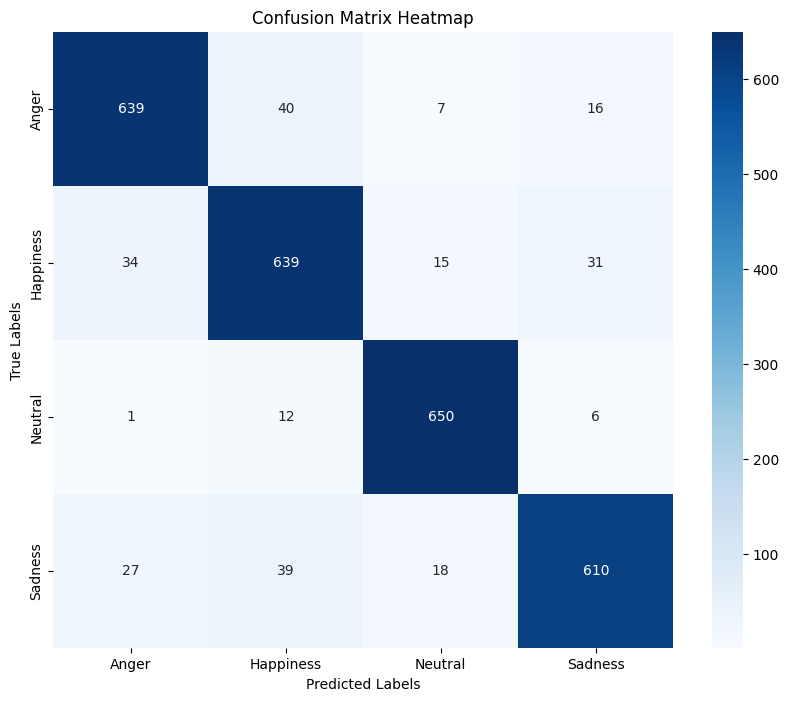

Train Accuracy: 0.9475
Validation Accuracy: 0.9174
Test Accuracy: 0.9116


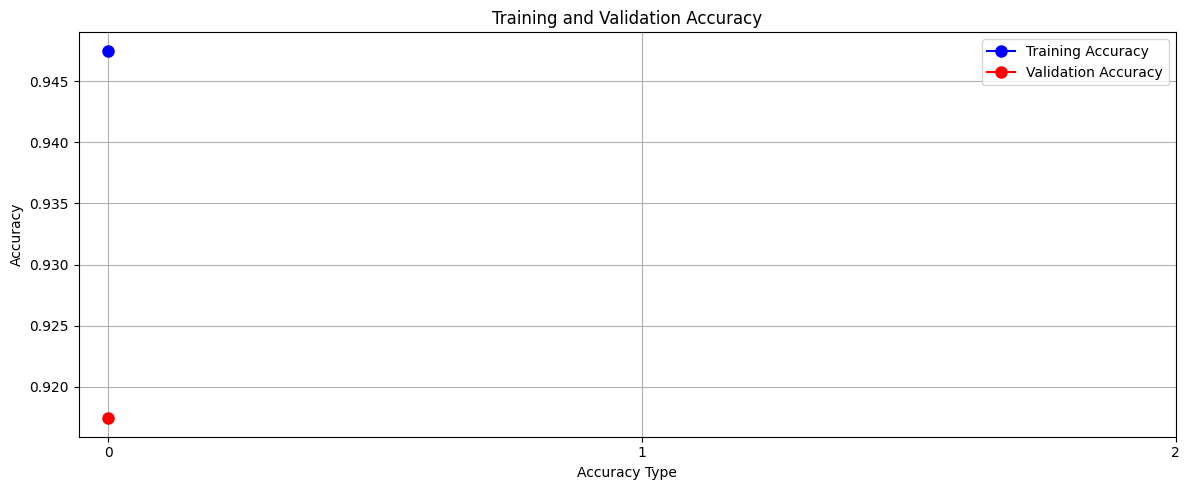

[learning_curve] Training set sizes: [ 801 2605 4408 6212 8016]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   13.5s finished


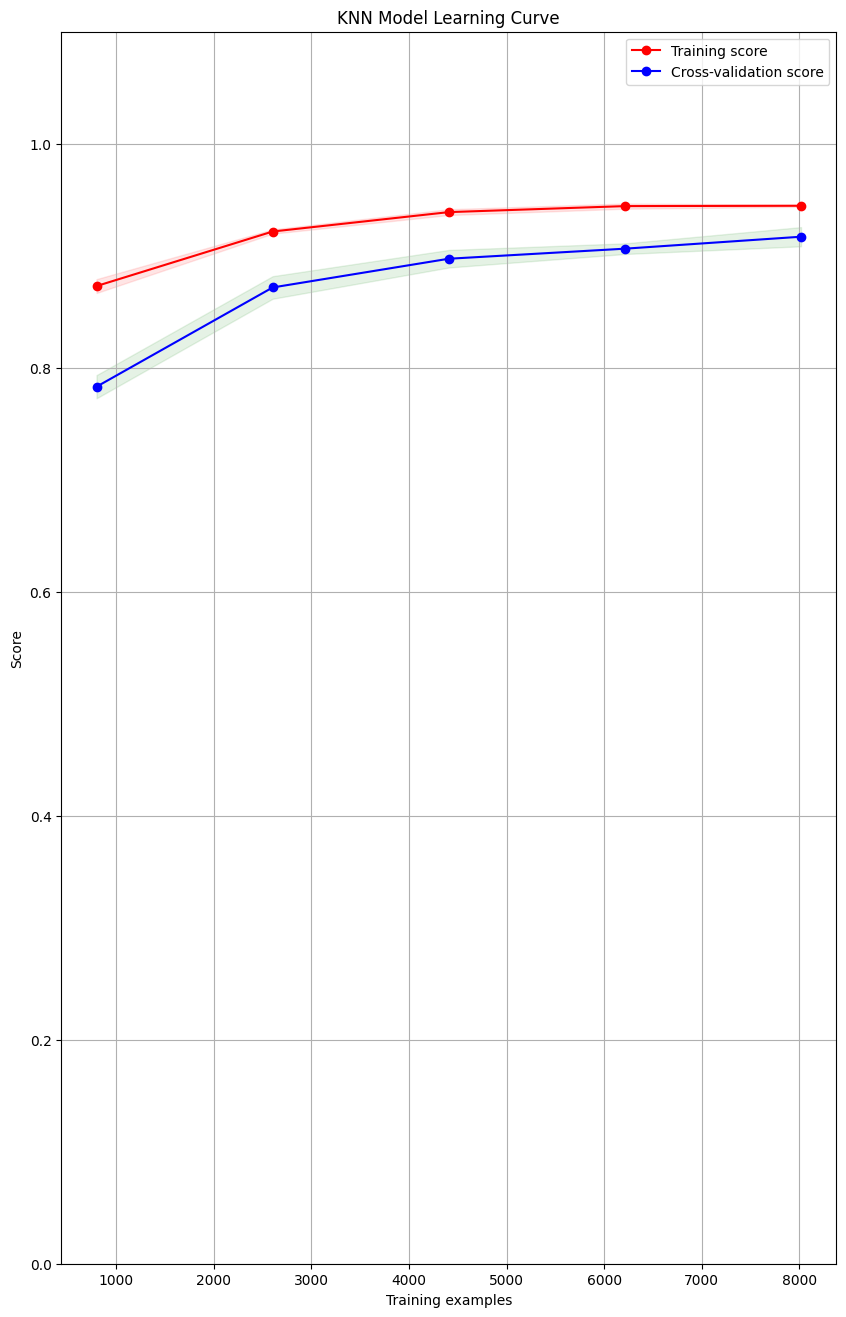

In [7]:
# Evaluate on training, validation, and test data
train_accuracy = accuracy_score(y_train, neigh.predict(X_train))
val_accuracy = accuracy_score(y_val, neigh.predict(X_val))
test_accuracy = accuracy_score(y_test, neigh.predict(X_test))

# Calculate confusion matrix for test data
prediction = neigh.predict(X_test)
conf_matrix = confusion_matrix(y_test, prediction)

# Plot confusion matrix heatmap
category_names = sorted(list(set(y_val).union(set(prediction))))  # Unique category names
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print final evaluation metrics
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot Accuracy (Single plot)
plt.figure(figsize=(12, 5))

# Accuracy plot (Training vs Validation vs Test) with labels
plt.plot([train_accuracy], label='Training Accuracy', marker='o', markersize=8, color='blue')
plt.plot([val_accuracy], label='Validation Accuracy', marker='o', markersize=8, color='red')
# plt.plot([test_accuracy], label='Test Accuracy', marker='o', markersize=8, color='blue')

# Customize the plot
plt.xticks([0, 1, 2])  # Set x-axis ticks for clarity
plt.xlabel('Accuracy Type')  # Label the x-axis
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.grid(True)  # Add a grid for better readability

plt.tight_layout()
plt.show()

from sklearn.model_selection import KFold, learning_curve
import matplotlib.pyplot as plt

# Define the KFold object for cross-validation
seed = 42
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Use learning_curve to calculate scores
train_sizes, train_scores, test_scores = learning_curve(
    neigh, X_train, y_train, n_jobs=-1, cv=kfold, train_sizes=np.linspace(.1, 1.0, 5), verbose=1
)

# Calculate mean and standard deviation of scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 16))
plt.title("KNN Model Learning Curve")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid(True)

# Plot the mean scores with standard deviation bands
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="b", label="Cross-validation score")

# Plot the test score as a separate line
# plt.plot(train_sizes, [test_accuracy] * len(train_sizes), 'o-', color='b', label='Test score')

# Set the y-axis limits
plt.ylim(0, 1.1)

# Add legend and show the plot
plt.legend(loc="best")
plt.show()

In [8]:
from sklearn.metrics import classification_report
print(classification_report(ts_labels, prediction, target_names=category_names))

              precision    recall  f1-score   support

       Anger       0.91      0.91      0.91       702
   Happiness       0.88      0.89      0.88       719
     Neutral       0.94      0.97      0.96       669
     Sadness       0.92      0.88      0.90       694

    accuracy                           0.91      2784
   macro avg       0.91      0.91      0.91      2784
weighted avg       0.91      0.91      0.91      2784



In [9]:
# Check for overlaps between train and test datasets
train_set = set(map(tuple, tr_features))
test_set = set(map(tuple, ts_features))
overlap = train_set.intersection(test_set)
print(f"Number of overlapping samples: {len(overlap)}")
print(conf_matrix)

Number of overlapping samples: 0
[[639  40   7  16]
 [ 34 639  15  31]
 [  1  12 650   6]
 [ 27  39  18 610]]


In [10]:
train_accuracy = neigh.score(tr_features, tr_labels)
test_accuracy = accuracy_score(ts_labels, prediction)
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Training Accuracy: 0.9379
Test Accuracy: 0.9116


In [11]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(neigh, tr_features, tr_labels, cv=5)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores):.4f}")

Cross-Validation Scores: [0.91199713 0.92528736 0.92097701 0.90621631 0.93424362]
Mean Cross-Validation Accuracy: 0.9197


In [12]:
misclassified_indices = np.where(ts_labels != prediction)[0]
print("Misclassified Samples:", misclassified_indices[:10])


Misclassified Samples: [ 3  8 24 29 34 36 45 47 53 71]
